In [1]:
!pip install torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:00


In [2]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 133.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [3]:
import torch
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import random
import time
import torch.nn.functional as F

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [4]:
RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 0.005
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2
VOCAB_SIZE=20000

torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [5]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [6]:
def yeild_tokens(data_iter):
    for _,text in data_iter:
        yield tokenizer(text)

In [7]:
class IMDBCSVDataset(Dataset):
    def __init__(self,csv):
        self.data=pd.read_csv(csv)
        self.data['sentiment']=self.data['sentiment'].map({'positive':1,'negative':0})

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        label=self.data.iloc[idx]['sentiment']
        text=self.data.iloc[idx]['review']
        return label,text

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
dataset=IMDBCSVDataset('/content/drive/My Drive/IMDB_sentiment_analysis/IMDB Dataset.csv')
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[0.8,0.2])
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[0.85,0.15])

print(f'Length of train dataset: {len(train_dataset)}')
print(f'Length of val dataset: {len(val_dataset)}')
print(f'Length of test dataset: {len(test_dataset)}')

Length of train dataset: 34000
Length of val dataset: 6000
Length of test dataset: 10000


In [11]:
vocab=build_vocab_from_iterator(yeild_tokens(train_dataset),max_tokens=VOCAB_SIZE,specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [12]:
def text_pipeline(x):
    tokens=tokenizer(x)
    indexed_token=[vocab[token] for token in tokens]
    return torch.tensor(indexed_token,dtype=torch.long)


In [13]:
def collate_fn(batch):
    labels,texts=[],[]
    for label,text in batch:
        labels.append(label)
        processed_text=text_pipeline(text)
        texts.append(processed_text)
    labels=torch.tensor(labels,dtype=torch.long)
    texts=pad_sequence(texts,batch_first=True,padding_value=vocab['<pad>'])
    return labels,texts

In [14]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [15]:
class luongAttention(nn.Module):
    def __init__(self,hidden_dim):
        super(luongAttention,self).__init__()
        self.attention=nn.Linear(hidden_dim,hidden_dim)
        self.score = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self,encoder_outputs):
        energy=torch.tanh(self.attention(encoder_outputs))
        scores=self.score(energy).squeeze(-1)
        attn_weights=F.softmax(scores,dim=1)

        context=torch.bmm(attn_weights.unsqueeze(1),encoder_outputs).squeeze(1)
        return context,attn_weights

class BiLSTMAttentionModel(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim,pad_idx):
        super(BiLSTMAttentionModel,self).__init__()
        self.embedding=nn.Embedding(input_dim,embedding_dim,padding_idx=pad_idx)
        self.lstm=nn.LSTM(embedding_dim,hidden_dim,bidirectional=True,batch_first=True)
        self.attention=luongAttention(hidden_dim*2)
        self.fc=nn.Linear(hidden_dim*2,output_dim)

    def forward(self,text):
        embedded=self.embedding(text)
        output,(hidden,cell)=self.lstm(embedded)
        attn_output,attn_weights=self.attention(output)
        out=self.fc(attn_output)
        return out, attn_weights

In [16]:
def compute_accuracy(model,data_loader):
    model.eval()
    correct_predictions=0
    total_predictions=0
    with torch.no_grad():
        for labels,texts in data_loader:
            labels=labels.to(DEVICE)
            texts=texts.to(DEVICE)
            outputs,_=model(texts)
            _,predicted=torch.max(outputs,1)
            correct_predictions+=(predicted==labels).sum().item()
            total_predictions+=labels.size(0)
    accuracy=correct_predictions/total_predictions
    return accuracy

In [17]:
torch.manual_seed(RANDOM_SEED)
model=BiLSTMAttentionModel(input_dim=len(vocab),embedding_dim=EMBEDDING_DIM,hidden_dim=HIDDEN_DIM,output_dim=NUM_CLASSES,pad_idx=vocab['<pad>'])
model=model.to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion=nn.CrossEntropyLoss()
criterion=criterion.to(DEVICE)
train_accs=[]
val_accs=[]

In [18]:
import time
import torch
import torch.nn as nn
# from compute_accuracy import compute_accuracy # Assuming this function exists

# --- 1. INITIALIZE EARLY STOPPING VARIABLES ---
BEST_VAL_ACC = 0.0
PATIENCE = 5  # Number of epochs to wait for improvement
PATIENCE_COUNTER = 0
EARLY_STOP = False

start = time.time()
for epoch in range(NUM_EPOCHS):
    if EARLY_STOP:
        print(f"Stopping early at Epoch {epoch} due to no improvement in validation accuracy for {PATIENCE} epochs.")
        break

    model.train()
    epoch_loss = 0

    # --- TRAINING PHASE ---
    for labels, texts in train_loader:
        labels = labels.to(DEVICE)
        texts = texts.to(DEVICE)
        optimizer.zero_grad()
        outputs, _ = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    # --- EVALUATION PHASE ---
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}: \n- Loss: {epoch_loss/len(train_loader):.4f} \n- Train Acc: {train_acc*100:.2f}% \n-Val Acc: {val_acc*100:.2f}% \n- Time: {((time.time()-start)/60.00):.2f} minutes')

    # --- 2. EARLY STOPPING LOGIC ---
    if val_acc > BEST_VAL_ACC:
        BEST_VAL_ACC = val_acc
        PATIENCE_COUNTER = 0  # Reset counter

        # Save the best model weights
        torch.save(model.state_dict(), 'best_model_weights.pth')
        print(f"    --> Validation accuracy improved. Saving model weights to 'best_model_weights.pth'.")
    else:
        PATIENCE_COUNTER += 1 # Increment counter
        print(f"    --> Validation accuracy did not improve. Patience: {PATIENCE_COUNTER}/{PATIENCE}")
        if PATIENCE_COUNTER >= PATIENCE:
            EARLY_STOP = True

# --- 3. LOAD BEST MODEL AFTER TRAINING/STOPPING ---
# If early stopping triggered, the loop breaks, and we load the best weights.
if EARLY_STOP:
    model.load_state_dict(torch.load('best_model_weights.pth'))
    print("Loaded best model weights saved during training.")

Epoch 1/15: 
- Loss: 0.3750 
- Train Acc: 93.08% 
-Val Acc: 89.10% 
- Time: 3.92 minutes
    --> Validation accuracy improved. Saving model weights to 'best_model_weights.pth'.
Epoch 2/15: 
- Loss: 0.1737 
- Train Acc: 98.04% 
-Val Acc: 91.00% 
- Time: 7.91 minutes
    --> Validation accuracy improved. Saving model weights to 'best_model_weights.pth'.
Epoch 3/15: 
- Loss: 0.0762 
- Train Acc: 99.11% 
-Val Acc: 89.87% 
- Time: 11.91 minutes
    --> Validation accuracy did not improve. Patience: 1/5
Epoch 4/15: 
- Loss: 0.0296 
- Train Acc: 99.63% 
-Val Acc: 89.93% 
- Time: 15.86 minutes
    --> Validation accuracy did not improve. Patience: 2/5
Epoch 5/15: 
- Loss: 0.0157 
- Train Acc: 99.83% 
-Val Acc: 89.88% 
- Time: 19.84 minutes
    --> Validation accuracy did not improve. Patience: 3/5
Epoch 6/15: 
- Loss: 0.0104 
- Train Acc: 99.87% 
-Val Acc: 90.18% 
- Time: 23.81 minutes
    --> Validation accuracy did not improve. Patience: 4/5
Epoch 7/15: 
- Loss: 0.0110 
- Train Acc: 99.84% 


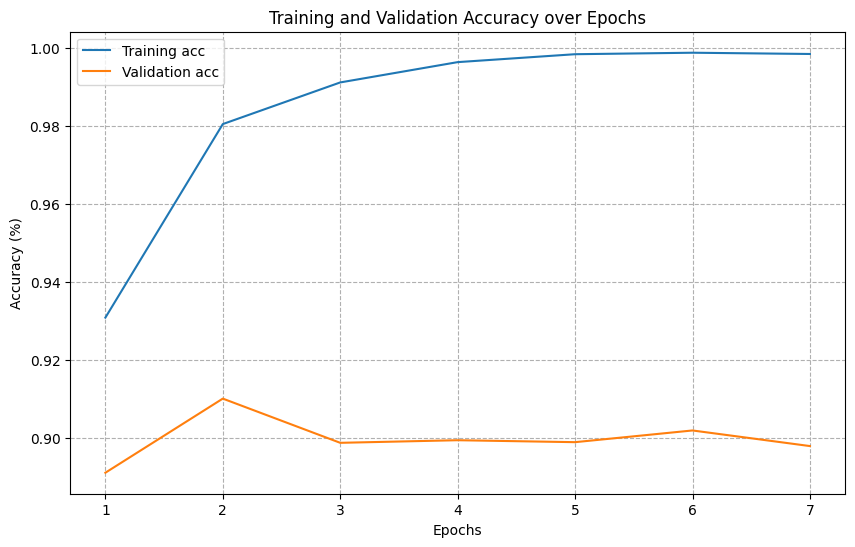

In [ ]:
import matplotlib.pyplot as plt

epochs_ran = len(train_accs)

plt.figure(figsize=(10, 6))

plt.plot(range(1, epochs_ran + 1), train_accs, label='Training acc')
plt.plot(range(1, epochs_ran + 1), val_accs, label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

In [22]:
compute_accuracy(model,test_loader)

0.9025